<a href="https://colab.research.google.com/github/cfont03/Anomaly-breast-cancer-detection/blob/main/train/1.%20Faster_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Data Upload

In [1]:
# Mount google drive
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Access and unzip images
!unzip "/content/gdrive/MyDrive/99_Output/all-mias.zip" -d "/"
print("DONE!")

Archive:  /content/gdrive/MyDrive/99_Output/all-mias.zip
replace /content/archive/all-mias/mdb120.pgm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
DONE!


In [3]:
# Importation of libraries
from tensorflow import keras 
print("Keras version   : ", keras.__version__)

%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten, Input,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, TimeDistributed)
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model

%pylab inline
import cv2
import glob
import os
import matplotlib.pylab as plt

#from PIL import Image
import PIL.Image
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image
from keras.preprocessing import image as kp_image
#from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
#import tensorflow_addons as tfa

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

import seaborn as sns
from matplotlib import patches
import time

Keras version   :  2.8.0
Populating the interactive namespace from numpy and matplotlib


In [7]:
# read csvs files from Data Cleansing
train = pd.read_csv("/content/gdrive/MyDrive/99_Output/images_preprocess_train.csv", sep = ";")
print('Training dataset: \n', train.head())

test = pd.read_csv("/content/gdrive/MyDrive/99_Output/images_preprocess_test.csv", sep = ";")
print('Testing dataset: \n', test.head())

Training dataset: 
    Unnamed: 0    name               features          size   cat  x_coord  \
0           0  mdb211  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC    680.0   
1           1  mdb271  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  MISC    784.0   
2           2  mdb212  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC    687.0   
3           3  mdb213  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC    547.0   
4           4  mdb184  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  SPIC    352.0   

   y_coord  radius                            image path   xmin   xmax   ymin  \
0    697.0      13  /content/archive/all-mias/mdb211.pgm  667.0  693.0  684.0   
1    754.0      68  /content/archive/all-mias/mdb271.pgm  716.0  852.0  686.0   
2    142.0       3  /content/archive/all-mias/mdb212.pgm  684.0  690.0  139.0   
3    504.0      45  /content/archive/all-mias/mdb213.pgm  502.0  592.0  459.0   
4    400.0     114  /content/archive/all-mias/mdb184.pgm  238.0  466.0  286.0   

    ymax  
0  710.0  
1  822.0

In [8]:
# show boundary box to image
def boundary_box (df):
  
  '''

  This function plots an image with its boundary boxes

  Params:
  1: name image
  8: path image
  9: min coord x
  10: max coord x
  11: min coord y
  12: max coord y

  '''

  image = input("introduce image name: ") 
  path = '/content/archive/all-mias/{:}'.format(image)
  im = cv2.imread(path)
  
  
  # generate x, y, width and height
  xmin = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,9]
  xmax = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,10]
  ymin = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,11]
  ymax = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,12]

  xmin, xmax, ymin, ymax = (xmin.values[0], xmax.values[0], ymin.values[0], ymax.values[0])
  width = xmax - xmin
  height = ymax - ymin

  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

introduce image name: mdb184.pgm


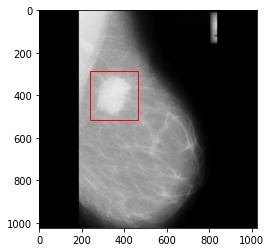

In [9]:
# apply to our df
boundary_box(train)


#1. Faster R-CNN

##1.1. Preprocess

In [10]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from urllib import request
from tensorflow.keras import initializers
np.set_printoptions(suppress=True)
from pathlib import Path

In [11]:
# keep interesting fields
train_ = train.iloc[:, [8, 9, 10, 11, 12]]
train_['height'] = 1024
train_['weight'] = 1024
train_['cat'] = train['cat']
train_.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,image path,xmin,xmax,ymin,ymax,height,weight,cat
410,/content/archive/all-mias/mdb023_mask.pgm,509.000000,567.000000,314.000000,372.000000,1024,1024,CIRC
411,/content/archive/all-mias/mdb270_hflip.jpeg,331.000000,357.000000,331.000000,357.000000,1024,1024,CIRC
412,/content/archive/all-mias/mdb270_noise.jpeg,284.000000,428.000000,7.000000,151.000000,1024,1024,CIRC
413,/content/archive/all-mias/mdb270_rotate.jpeg,369.871537,126.626804,369.871537,126.626804,1024,1024,CIRC
414,/content/archive/all-mias/mdb270_mask.pgm,284.000000,428.000000,7.000000,151.000000,1024,1024,CIRC


In [12]:
# resizing input images to fit into pretrained model, to extract features
def resize (df, h = 800, w = 800):
  
  '''

  Function returns resized images to specified size. Format: df
  Default is 800 x 800.

  Params:
  0: image path
  1: xmin
  2: xmax
  3: ymin
  4: ymax
  5: height original image
  6: weight original image
  7: label

  '''

  paths = []
  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  labels = []

  for i in df.iloc:
    img = cv2.imread(str(i[0]))
    img = cv2.resize(img, dsize = (h,w), interpolation = cv2.INTER_CUBIC)
    path, filename_ext = os.path.split(i[0])
    filename = os.path.basename(i[0]).split('.')[0]
    new_path = Path(str(path)+'/{:}_resize{:}'.format(filename, '.jpeg')) # generate new path
    status = cv2.imwrite(str(new_path), img)
    print("Image written to file-system " , new_path,  " :", status) # check if saved
    paths.append(new_path)

    x_factor = w / i[5]
    y_factor = h / i[6]

    # adapt bounding box accordingly
    xmin = i[1] * x_factor
    xmins.append(xmin)
    xmax = i[2] * x_factor
    xmaxs.append(xmax)
    ymin = i[3] * y_factor
    ymins.append(ymin)
    ymax = i[4] * y_factor
    ymaxs.append(ymax)

    labels.append(i[7])

  arr = np.array([paths, xmins, xmaxs, ymins, ymaxs, labels], dtype = object).T.tolist()
  df_ = pd.DataFrame(data = arr, columns = ['image path', 'xmin', 'xmax', 'ymin', 'ymax', 'labels'])
  
  return df_

In [ ]:
# apply to df
train_re = resize(train_, 800, 800)

In [14]:
train_re.head() # check results

,image path,xmin,xmax,ymin,ymax,labels
0,/content/archive/all-mias/mdb211_resize.jpeg,521.09375,541.40625,534.37500,554.68750,CALC
1,/content/archive/all-mias/mdb271_resize.jpeg,559.37500,665.62500,535.93750,642.18750,MISC
2,/content/archive/all-mias/mdb212_resize.jpeg,534.37500,539.06250,108.59375,113.28125,CALC
3,/content/archive/all-mias/mdb213_resize.jpeg,392.18750,462.50000,358.59375,428.90625,CALC
4,/content/archive/all-mias/mdb184_resize.jpeg,185.93750,364.06250,223.43750,401.56250,SPIC


In [17]:
# show boundary box to resized image

def boundary_box_resize (df):
  
  '''

  This function plots an image with its boundary boxes

  Params:
  0: path image
  1: min coord x
  2: max coord x
  3: min coord y
  4: max coord y
  5: label

  '''

  image = input("introduce image name: ") 
  path = '/content/archive/all-mias/{:}'.format(image)
  im = cv2.imread(path)
  
  # generate x, y, width and height
  xmin = df[df['image path'].apply(lambda x : x == (Path(path)))].iloc[:,1]
  xmax = df[df['image path'].apply(lambda x : x == (Path(path)))].iloc[:,2]
  ymin = df[df['image path'].apply(lambda x : x == (Path(path)))].iloc[:,3]
  ymax = df[df['image path'].apply(lambda x : x == (Path(path)))].iloc[:,4]

  xmin, xmax, ymin, ymax = (xmin.values[0], xmax.values[0], ymin.values[0], ymax.values[0])
  width = xmax - xmin
  height = ymax - ymin



  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

introduce image name: mdb184_resize.jpeg


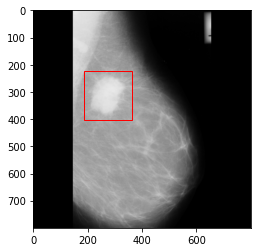

In [18]:
boundary_box_resize(train_re)

## 1.2. Training

###1.2.1. VGG16 Model

In [19]:
from numpy.core.fromnumeric import shape

# VGG Network
def vgg16_cnn(df, h = 800, w = 800, c = 3):

  '''

  This function uses pre-trained vgg16 model to extract the feature map of the passed images. 

  Params: df with
  0: image path

  Returns: 
  - output model of vgg16
  - feature map
  - df with additional info:
  w_fm: width of the feature map
  h_fm: height of the feature map
  n_anchors: number of potential anchors per image

  '''

  # show execution time
  start_time = time.time()



  # --------------- vgg16 model -------------
   
  vgg16_model = tf.keras.applications.VGG16(
    include_top=False,  # don't include last layer of pre-trained vgg16 model
    weights='imagenet', # weights of imagenet
    input_shape = (w, h, c) # size of img
  )

  for layer in vgg16_model.layers:
    layer.trainable = True # trainable parameters


  # train data
  train_images = []
  
  for i in df.iloc:
    img = cv2.imread(str(i[0]))
    train_images.append(img)

  train_images = np.array(train_images)
  train_images = train_images/255 #normalize

  feature_map = vgg16_model.predict(train_images)


  # feature map
  anchors = []
  w_fms = []
  h_fms = []
  features = []

  for i in df.iloc:
    img = cv2.imread(str(i[0]))
    fm = vgg16_model.predict(np.expand_dims(img, 0))
    _, w_fm, h_fm, _ = fm.shape # feature map size
    n_anchor = w_fm * h_fm    # calculate number of anchors per image
    anchors.append(n_anchor)
    w_fms.append(w_fm)
    h_fms.append(h_fm)



  # add sizes of feature map in the df
  df['n_anchor'] = anchors
  df['w_fm'] = w_fms # width of feature map
  df['h_fm'] = h_fms # height of feature map



  print(f"\n------- Execution time: {(time.time() - start_time)/60:.2f} minutes -------\n")
  print('Number of anchors needed: ', n_anchor)
  print('\n', vgg16_model.summary())
  
  
  return df, vgg16_model, feature_map


In [20]:
train_re, vgg16_model, feature_map = vgg16_cnn(train_re)

58900480/58889256 [==============================] - 0s 0us/step

------- Execution time: 6.88 minutes -------

Number of anchors needed:  625
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 800, 800, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 800, 800, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 800, 800, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 400, 400, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 400, 400, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 400, 400, 128)

In [21]:
### CHECKPOINT - SAVE INTO DRIVE
train_re.to_csv("/content/archive/train_re.csv", sep = ";") # save file
!cp "/content/archive/train_re.csv" "/content/gdrive/MyDrive/99_Output"

In [22]:
### CHECKPOINT - SAVE INTO DRIVE
np.save('/content/archive/feature_map', feature_map) # save file
!cp "/content/archive/feature_map.npy" "/content/gdrive/MyDrive/99_Output"

In [84]:
train_re = pd.read_csv("/content/gdrive/MyDrive/99_Output/train_re.csv", sep = ";")

In [85]:
train_re.head()

,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm
0,0,/content/archive/all-mias/mdb211_resize.jpeg,521.09375,541.40625,534.37500,554.68750,CALC,625,25,25
1,1,/content/archive/all-mias/mdb271_resize.jpeg,559.37500,665.62500,535.93750,642.18750,MISC,625,25,25
2,2,/content/archive/all-mias/mdb212_resize.jpeg,534.37500,539.06250,108.59375,113.28125,CALC,625,25,25
3,3,/content/archive/all-mias/mdb213_resize.jpeg,392.18750,462.50000,358.59375,428.90625,CALC,625,25,25
4,4,/content/archive/all-mias/mdb184_resize.jpeg,185.93750,364.06250,223.43750,401.56250,SPIC,625,25,25


###1.2.2. Anchor points

In [86]:
def anchor_points (df, w = 800, h = 800):

    '''
    
    This function plots a random image with its possible anchor boxes and adds the centre of coordinates x and y into columns in df.


    Params: df with:
    1: image path
    2: min x coord
    3: max x coord
    4: min y coord
    5: max y coord
    6: class
    7: number of anchors
    8: feature map width
    9: feature map height

    width and height of . default at 800

    Output: plot of random image with possible anchors and df with additional info:
    - Number of possible anchors per image (n_anchors)
    - width of feature map (w_fm)
    - height of feature map (h_fm)
    - centre_list: list with (x,y) anchor points of the image
    
    '''


    # -------- calculate the centre of anchor image for all images --------

    centre_lists, x_strs, y_strs = [], [], []

    for i in df.iloc:
      img_path = i[1]
      
      x = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,8]
      x_str = int(w / int(x.values[0]))
      y = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,9]
      y_str = int(h / int(y.values[0]))
      
      # centre anchor image
      x_centre = np.arange(8, w, x_str) 
      y_centre = np.arange(8, h, y_str)
      centre_list = np.array(np.meshgrid(x_centre, y_centre,  sparse=False, indexing='xy')).T.reshape(-1,2)

      centre_lists.append(centre_list)

    # add info to the df
    df['x_str'] = x_str
    df['y_str'] = y_str
    df['anchor_points'] = centre_lists



    # ------------- plot image -------------

    # take one random image
    path, filename = os.path.split(df.iloc[0][1]) # take path from first element in the df
    img_rand = random.choice([x for x in os.listdir(path) 
                            if (os.path.isfile(os.path.join(path, x)) and len(x) >= 18)]) # only image with '_resize'

    img_path = (path)+'/{:}'.format(img_rand)
    img_path = str('/content/archive/all-mias/mdb002_resize.jpeg')
    img_ = cv2.imread(img_path)
    
    centre_list_r1 = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,-1] # take the centre list from the random image
    centre_list_r1 = centre_list_r1.values[0]

    # plot anchor positions 
    plt.figure(figsize=(9, 6))
    

    a = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,7]
    b = a.values[0]
    for i in range(b):
      cv2.circle(img_, (int(centre_list_r1[i][0]), int(centre_list_r1[i][1])), radius=1, color=(255, 0, 0), thickness=5) 
      
    print('Image name: ', img_rand)
    plt.imshow(img_)
    plt.show()


    return df

Image name:  mdb226_hflip_resize.jpeg


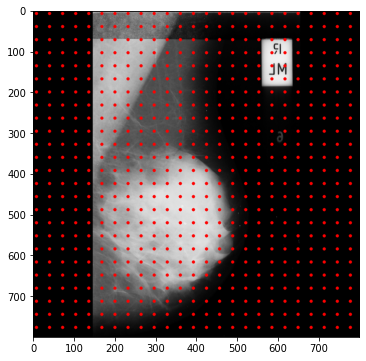

,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,x_str,y_str,anchor_points
0,0,/content/archive/all-mias/mdb211_resize.jpeg,521.093750,541.406250,534.375000,554.687500,CALC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
1,1,/content/archive/all-mias/mdb271_resize.jpeg,559.375000,665.625000,535.937500,642.187500,MISC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
2,2,/content/archive/all-mias/mdb212_resize.jpeg,534.375000,539.062500,108.593750,113.281250,CALC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
3,3,/content/archive/all-mias/mdb213_resize.jpeg,392.187500,462.500000,358.593750,428.906250,CALC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
4,4,/content/archive/all-mias/mdb184_resize.jpeg,185.937500,364.062500,223.437500,401.562500,SPIC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,410,/content/archive/all-mias/mdb023_mask_resize.jpeg,397.656250,442.968750,245.312500,290.625000,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
411,411,/content/archive/all-mias/mdb270_hflip_resize....,258.593750,278.906250,258.593750,278.906250,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
412,412,/content/archive/all-mias/mdb270_noise_resize....,221.875000,334.375000,5.468750,117.968750,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."
413,413,/content/archive/all-mias/mdb270_rotate_resize...,288.962138,98.927191,288.962138,98.927191,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],..."


In [87]:
anchor_points(train_re)

### 1.2.3. Anchor boxes

In [88]:
def anchor_boxes (df, w= 800, h = 800):

    
  ''' This function calculates the anchor boxes per image and plots one random image. It additionally adds the anchor boxes in an array.
  
  Params: 
  
  - df with:
  1: image path
  2: min x coord
  3: max x coord
  4: min y coord
  5: max y coord
  6: class
  7: number of anchors
  8: feature map of width
  9: feature map height
  10: anchor centre of fm, x coord
  11: anchor centre of fm, y coord
  12: list of centre coords in img (x,y)

  width and height. default at 800

  Output: plot of random image with anchors and df with additional info:
  - anchor boxes per image
    
  '''

    
  # ------------- calculate anchor boxes per image -------------

  l = []
        
  # aspect ratio width and height
  anchor_ratio_l = [0.5, 1, 2] # 3 scenarios: vertical rect (width is half height), square (width = height), horizontal rect (width is twice hight)
  anchor_scale_l = [128, 256, 512] # anchor box area, according to original paper ([8, 16, 32] first trial)


  total_anchors = []
  n_objects = []
  anchors_list = []
  anchors_lists = []

  # rpn is passed into conv. layer with 3x3 filters
  for i in df.iloc:
    n_anchors = i[7] * len(anchor_ratio_l) * len(anchor_scale_l) # number of possible anchors
    total_anchors.append(n_anchors)
    bbox_list = np.array([i[2], i[4], i[3], i[5]]) # boundary box in np
    n_object = len(bbox_list) # number of objects in the image
    n_objects.append(n_object)
    anchor_list = np.zeros(shape= (n_anchors, 4))
          
    count = 0
    centre_list_ = i[-1]
    x_str = i[-3]
    y_str = i[-2]

    # for each anchor point
    for centre in centre_list_:
      centre_x, centre_y = centre[0], centre[1]
      # for each ratio
      for ratio in anchor_ratio_l:
        # for each scale
        for scale in anchor_scale_l:
        # compute height and width and scale them by constant factor
          h = pow(pow(scale, 2)/ ratio, 0.5)
          w = h * ratio

          # scale h and w
          h *= x_str
          w *= y_str


          # * at this point we have height and width of anchor and centers of anchor locations
          # putting anchor 9 boxes at each anchor locations (3x3 filters)
          anchor_xmin = centre_x - 0.5 * w
          anchor_xmax = centre_x + 0.5 * w
          anchor_ymin = centre_y - 0.5 * h
          anchor_ymax = centre_y + 0.5 * h
          l.append([centre_x, centre_y, w, h])     
          
          # append the anchor box to anchor list
          anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
          anchors_list.append(anchor_list)
                
          count += 1
        
    anchors_lists.append(anchors_list)
      
  # add values to the df
  df['n_possible_anchors'] = total_anchors
  df['n_object'] = n_objects
  df['possible_anchors'] = anchors_lists


  
  # ------------ visualize anchor boxes at center anchor location of a random image
  # take one random image
  path, filename = os.path.split(df.iloc[0][1]) # take path from first element in the df
  img_rand = random.choice([x for x in os.listdir(path) 
                            if (os.path.isfile(os.path.join(path, x)) and len(x) >= 18)]) # only image with '_resize' 
                            ################## fix this!! needs to be random within passed df data

  img_path = (path)+'/{:}'.format(img_rand)
  img_path = str('/content/archive/all-mias/mdb002_resize.jpeg')
  img_ = cv2.imread(img_path)

  centre_list_r2 = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,12] # take the centre list from the random image
  centre_list_r2 = centre_list_r2.values[0]


  # mid anchor centre = 625/2 = 312.5
  anchor = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,7]
  anchor = anchor.values[0]
  range1 = int(round(anchor/2 * 9, 0))

  ######## fix this part ##########
  anchor_list = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,-1]
  anchor_list = anchor_list.values[0]

  for i in range(range1, range1+9):  # 312.5 * 9 = 2812.5 (9 anchors corresponds to mid anchor center)
    x_min = int(anchor_list[0][i][0])
    y_min = int(anchor_list[0][i][1])
    x_max = int(anchor_list[0][i][2])
    y_max = int(anchor_list[0][i][3])
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=3) 

  ########## until here ##########

  bbox_lists = []
  for i in df.iloc:
    bbox_list = np.array([i[2], i[4], i[3], i[5]])
    bbox_lists.append(bbox_list)

  df['bbox_list'] = bbox_lists


  ground_truth = df[df['image path'].apply(lambda x : x == str(Path(img_path)))].iloc[:,-1]
  ground_truth = ground_truth.values[0]

  #for i, bbox in enumerate(ground_truth):
    #cv2.rectangle(img_, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color=(0, 255, 0), thickness=3)
  cv2.rectangle(img_, (int(ground_truth[0]), int(ground_truth[1])), (int(ground_truth[2]), int(ground_truth[3])), color=(0, 255, 0), thickness=3)       
  
  cv2.circle(img_, (int(centre_list_r2[312][0]), int(centre_list_r2[312][1])), radius=1, color=(0, 0, 255), thickness=15) 

  plt.imshow(img_)
  plt.show()


  return df

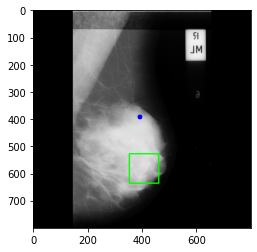

,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,x_str,y_str,anchor_points,n_possible_anchors,n_object,possible_anchors,bbox_list
0,0,/content/archive/all-mias/mdb211_resize.jpeg,521.093750,541.406250,534.375000,554.687500,CALC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[521.09375, 534.375, 541.40625, 554.6875]"
1,1,/content/archive/all-mias/mdb271_resize.jpeg,559.375000,665.625000,535.937500,642.187500,MISC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[559.375, 535.9375, 665.625, 642.1875]"
2,2,/content/archive/all-mias/mdb212_resize.jpeg,534.375000,539.062500,108.593750,113.281250,CALC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[534.375, 108.59375, 539.0625, 113.28125]"
3,3,/content/archive/all-mias/mdb213_resize.jpeg,392.187500,462.500000,358.593750,428.906250,CALC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[392.1875, 358.59375, 462.5, 428.90625]"
4,4,/content/archive/all-mias/mdb184_resize.jpeg,185.937500,364.062500,223.437500,401.562500,SPIC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[185.9375, 223.4375, 364.0625, 401.5625]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,410,/content/archive/all-mias/mdb023_mask_resize.jpeg,397.656250,442.968750,245.312500,290.625000,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[397.65625, 245.3125, 442.96875, 290.625]"
411,411,/content/archive/all-mias/mdb270_hflip_resize....,258.593750,278.906250,258.593750,278.906250,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[258.59375, 258.59375, 278.90625, 278.90625]"
412,412,/content/archive/all-mias/mdb270_noise_resize....,221.875000,334.375000,5.468750,117.968750,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[221.875, 5.46875, 334.375, 117.96875]"
413,413,/content/archive/all-mias/mdb270_rotate_resize...,288.962138,98.927191,288.962138,98.927191,CIRC,625,25,25,32,32,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[288.9621382668, 288.9621382668, 98.9271908229..."


In [89]:
anchor_boxes(train_re)

### 1.2.4. Regional Proposal Network 

In [90]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

def rpn (base_layer, w = 800, h = 800, c = 3):

  '''

  This function calculates the scores of each anchor box, as well as the deltas 

  '''

  # show execution time
  start_time = time.time()


  input_img = Input(shape = (w, h, c))
  
  vgg16 = base_layer(input_img, training = True)
  
  x = Conv2D(512, kernel_size = (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(vgg16) # conv layer with filter 3x3

  x_scores = Conv2D(9 * 1, kernel_size = (1, 1), activation='sigmoid', ## 9 * 2 or just 9 ????? 9 *2 would be FG and BG
                   kernel_initializer='uniform', name='rpn_out_class')(x) # conv layer for classification (whether the box is an object (FG) or background (BG))
  x_deltas = Conv2D(9 * 4, kernel_size = (1, 1), activation='linear',  
                                        kernel_initializer='zero', name='rpn_out_regress')(x) # conv layer for regression

    
  
  model = Model(inputs = [input_img] , outputs = [x_scores, x_deltas])
  
  model.summary()


  optimizer = Adam(learning_rate=1e-5)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', run_eagerly=True) # binary, as it can be FG or BG
  

  print(f"\n------- Execution time: {(time.time() - start_time)/60:.2f} minutes -------\n")

  return model, x_scores, x_deltas

In [91]:
rpn_model, x_scores, x_deltas = rpn(vgg16_model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 25, 25, 512)  14714688    ['input_2[0][0]']                
                                                                                                  
 rpn_conv1 (Conv2D)             (None, 25, 25, 512)  2359808     ['vgg16[0][0]']                  
                                                                                                  
 rpn_out_class (Conv2D)         (None, 25, 25, 9)    4617        ['rpn_conv1[0][0]']          

In [111]:
# prepare images
x_train = []
for i in train_re.iloc:
  img = cv2.imread(str(i[1]))
  x_train.append()

x_train = np.array(x_train)


# pass these into the scores and adjustments
pred_x_score, pred_x_deltas  = rpn_model.predict(x_train) # first value returns feature map

(800, 800, 3)
(4,)
(800, 800, 3)
(4,)
(800, 800, 3)
(4,)
(800, 800, 3)
(4,)


In [93]:
#### CHECKPOINT
# save results into the system
np.save('/content/archive/pred_x_scores', pred_x_score) # save file
!cp "/content/archive/pred_x_scores.npy" "/content/gdrive/MyDrive/99_Output"

np.save('/content/archive/pred_x_deltas', pred_x_deltas) # save file
!cp "/content/archive/pred_x_deltas.npy" "/content/gdrive/MyDrive/99_Output"

### 1.2.5. Non-maximum suppression

In [112]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    
    if len(boxes) == 0:
        return []


    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    #np.testing.assert_array_less(x1, x2)
    #np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection
        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    print(boxes)
    probs = probs[pick]
    
    return boxes, probs

### 1.2.6. Regions of interest

In [113]:
def rpn_to_roi (x_scores, x_deltas, std_scaling = 4):

  '''
  '''

  assert x_scores.shape[0] == x_deltas.shape[0] # both params must contain the same number of images

  x_deltas = x_deltas / std_scaling
  num_images = x_scores.shape[0]

  results = [] # results of each image will be appended

  for i in range(num_images): # for each image
  
    A = np.zeros((4, x_deltas.shape[1], x_deltas.shape[2], x_deltas.shape[3]))
    
    
    (rows, cols) = x_scores.shape[1:3]

    # aspect ratio width and height
    anchor_ratio_l = [[1,1], [1,2], [2,1]] # 3 scenarios: square (width = height), vertical rect (width is half height), horizontal rect (width is twice hight)
    anchor_scale_l = [128, 256, 512] # anchor box area, according to original paper ([8, 16, 32] first trial)


    curr_layer = 0

    # calculate proportions (same as in the previous function: anchor_boxes)
    for scale in anchor_scale_l:
      for ratio in anchor_ratio_l:
        ratio_x = scale * ratio[0]
        ratio_y = scale * ratio[1]

        X, Y = np.meshgrid(np.arange(cols),np. arange(rows))
    
        # calculate anchor position and size for eache feature point
        A[0, :, :, curr_layer] = X - ratio_x/2 # Top left x coordinate
        A[1, :, :, curr_layer] = Y - ratio_y/2 # Top left y coordinate
        A[2, :, :, curr_layer] = ratio_x       # width of current anchor
        A[3, :, :, curr_layer] = ratio_y       # height of current anchor
        
        regr_ = x_deltas[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (25, 25, 4)
        regr = np.transpose(regr_, (2, 0, 1)) # shape => (4, 25, 25)


        # apply regression to x,y,w,h
        #A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)
        X = A[:, :, :, curr_layer]
        T = regr
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        
        A[:, :, :, curr_layer] = np.stack([x1, y1, w1, h1])

        # Avoid width and height exceeding 1
        A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
        A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

        # Convert (x, y , w, h) to (x1, y1, x2, y2)
        # x1, y1 is top left coordinate
        # x2, y2 is bottom right coordinate
        A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
        A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

        # Avoid bboxes drawn outside the feature map
        A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
        A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
        A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
        A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])
        
        curr_layer += 1

    
    all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(22500, 4), 22500 = 25 * 25 * 36
    all_probs = x_scores[i].transpose((2, 0, 1)).reshape((-1))    # shape=(5625,)      5625 = 25 * 25 * 9         
    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]

    #print(x1, y1, x2, y2)

    # Find out the bboxes which are illegal and delete them from bboxes list
    idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

    #print(shape(idxs))
    #all_boxes = np.delete(all_boxes, idxs, 0)
    #all_probs = np.delete(all_probs, idxs, 0)

    result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=1, max_boxes=300)[0]
    results.append(result)


  return results
  #return all_boxes, all_probs

In [ ]:
results = rpn_to_roi(pred_x_score, pred_x_deltas)

In [518]:
results2 = []

for i in results:
  results2.append(i[0])


print(shape(results2))
results2

train_re['rois'] = results

(415, 4)


In [ ]:
train_re.head()

### 1.2.7. Intersection over union

In [524]:
def IoU_faster_rcnn (df):
    
    '''

    Calculate Intersection of Union (IoU) between predicted box and ground truth. 

    Params: df containing info on images
    1: image path
    2: x min coord
    3: x max coord
    4: y min coord
    5: y max coord
    6: label
    7: number of anchors
    8: width feature map
    9: height feature map
    10: centre x
    11: centre y
    12: centre list
    13: number of possible anchors
    14: number of objects
    15: anchor: predicted anchors in arrays. Sorted by xmax, ymax, xmin, ymin
    16: boundary box: ground truth in array. Sorted by xmax, ymax, xmin, ymin
    17: rois: predicted rois in arrays. Sorted by xmax, ymax, xmin, ymin

    Returns: An additional column in passed df with a list of arrays with the obtained IoUs. An extra column with the avg IoU per image
    and it also prints the avg IoU of the model.
    
    '''
    

    # Look for anchor boxes, which are indeed inside the image

    
    anchors = df.iloc[:,17]
    in_anchor_lists = []
    n_in_anchors = []

    for i in anchors:
      in_anchor_idx_list = np.where(
            (i[:,0] >= 0) &
            (i[:,1] >= 0) &
            (i[:,2] <= 800) & 
            (i[:,3] <= 800))[0]
      in_anchor_list = i[in_anchor_idx_list]
      in_anchor_lists.append(in_anchor_list)
      n_in_anchor = len(in_anchor_idx_list)
      n_in_anchors.append(n_in_anchor)

    df['inside_anchor_list'] = in_anchor_lists # column 18
    df['n_inside_anchor'] = n_in_anchors # column 19

    
    # ------calculate coordinate of overlapping region------

    ious = []
    ious_ = []

    truth = df.iloc[:,16]
    pred = df.iloc[:,17]
    
    for truth, pred in zip(truth, pred):
      i = 0
      for i in range(len(pred)):
        # take max of x1 and y1 out of both boxes
        x1 = max(truth[0], pred[i][0])
        y1 = max(truth[1], pred[i][1])
        # take min of x2 and y2 out of both boxes
        x2 = min(truth[2], pred[i][2])
        y2 = min(truth[3], pred[i][3])
      
        
        # ------area of overlapping region------
        if (x2 < x1 and y2 < y1): # if they don't overlap at all
          width_overlap = 0
          height_overlap = 0
        else:
          width_overlap = (x2 - x1)
          height_overlap = (y2 - y1)

        area_overlap = width_overlap * height_overlap
        area_overlap = [x for x in np.nditer(area_overlap) if x > 0] # keep only positive values
        #area_overlaps.append(area_overlap)      

      
        # ------computing union------
        # sum of area of both the boxes - area_overlap
        
        # height and width of both boxes
        width_truth = (truth[2] - truth[0])
        height_truth = (truth[3] - truth[1])

        width_pred = (pred[i][2] - pred[i][0])
        height_pred = (pred[i][3] - pred[i][1])
        
        # area of box1 and box2
        area_truth = width_truth * height_truth
        area_pred = width_pred * height_pred
        
        # union (including 2 * overlap area (double count))
        area_union_overlap = area_truth + area_pred
        
        # union
        area_union = area_union_overlap - area_overlap
        
        # compute IOU
        iou = area_overlap/ area_union

        if len(iou) < 1:
          iou = 0
        else:
          iou = iou[0]

        ious_.append(iou)

        i += 1
      
      ious.append(ious_)
s
    df['iou'] = ious
    
    
    # ------ calculate total IoU for the model ------

    avg_ious = []

    for i in df.iloc[:,20]: ## average per image
      avg_iou = sum(i) / len(i)
      avg_ious.append(avg_iou)

    df['avg_iou'] = avg_ious

    avg_iou_model = sum(avg_ious) / len(avg_ious) ## average total model

    print('\n Average IoU value of the Faster R-CNN model is: ', avg_iou_model)


    return df

In [525]:
IoU_faster_rcnn(train_re) # apply to our dataset


 Average IoU value of the Faster R-CNN model is:  0.0


,Unnamed: 0,image path,xmin,xmax,ymin,ymax,labels,n_anchor,w_fm,h_fm,...,centre_list,possible_anchors,n_object,anchor_list,bbox_list,rois,inside_anchor_list,n_inside_anchor,iou,avg_iou
0,0,/content/archive/all-mias/mdb211_resize.jpeg,521.093750,541.406250,534.375000,554.687500,CALC,625,25,25,...,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[521.09375, 534.375, 541.40625, 554.6875]","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...",300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1,1,/content/archive/all-mias/mdb271_resize.jpeg,559.375000,665.625000,535.937500,642.187500,MISC,625,25,25,...,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[559.375, 535.9375, 665.625, 642.1875]","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...",300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
2,2,/content/archive/all-mias/mdb212_resize.jpeg,534.375000,539.062500,108.593750,113.281250,CALC,625,25,25,...,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[534.375, 108.59375, 539.0625, 113.28125]","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...",300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,3,/content/archive/all-mias/mdb213_resize.jpeg,392.187500,462.500000,358.593750,428.906250,CALC,625,25,25,...,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[392.1875, 358.59375, 462.5, 428.90625]","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...",300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,4,/content/archive/all-mias/mdb184_resize.jpeg,185.937500,364.062500,223.437500,401.562500,SPIC,625,25,25,...,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[185.9375, 223.4375, 364.0625, 401.5625]","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...",300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,410,/content/archive/all-mias/mdb023_mask_resize.jpeg,397.656250,442.968750,245.312500,290.625000,CIRC,625,25,25,...,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[397.65625, 245.3125, 442.96875, 290.625]","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...",300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
411,411,/content/archive/all-mias/mdb270_hflip_resize....,258.593750,278.906250,258.593750,278.906250,CIRC,625,25,25,...,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[258.59375, 258.59375, 278.90625, 278.90625]","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...",300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
412,412,/content/archive/all-mias/mdb270_noise_resize....,221.875000,334.375000,5.468750,117.968750,CIRC,625,25,25,...,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[221.875, 5.46875, 334.375, 117.96875]","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...","[[0, 0, 24, 24], [0, 0, 24, 24], [0, 0, 24, 24...",300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
413,413,/content/archive/all-mias/mdb270_rotate_resize...,288.962138,98.927191,288.962138,98.927191,CIRC,625,25,25,...,"[[8, 8], [8, 40], [8, 72], [8, 104], [8, 136],...",5625,4,"[[[-1440.1546878700494, -2888.309375740099, 14...","[288.9621382668, 288.96213826

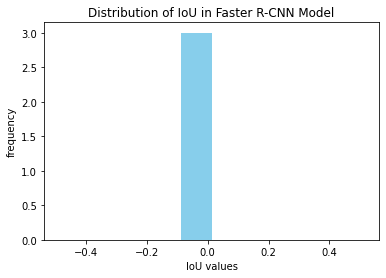

In [ ]:
# plot frequency of IoU images

plt.hist(df1['avg_iou'], color = 'skyblue')
plt.title('Distribution of IoU in Faster R-CNN Model')
plt.xlabel('IoU values')
plt.ylabel('frequency')
plt.show()

In [ ]:
## check how many images have an IoU of a certain threshold

threshold = 0.02 #### over 0.5 is considered to be good
df1[df1['avg_iou'] > threshold].count()

Unnamed: 0            0
path                  0
xmin                  0
xmax                  0
ymin                  0
ymax                  0
labels                0
n_anchor              0
w_fm                  0
h_fm                  0
x_str                 0
y_str                 0
centre_list           0
possible_anchors      0
n_object              0
anchor_list           0
bbox_list             0
inside_anchor_list    0
n_inside_anchor       0
iou                   0
avg_iou               0
dtype: int64

In [ ]:
all_boxes, all_probs = rpn_to_roi(pred_x_score, pred_x_deltas)

## 1.3. Testing